<a href="https://colab.research.google.com/github/Kryptera-K/PLTR-GannCCI-KC-B-Momentum-Strategy/blob/main/PLTR_D1_%5B'BullP_Rising'_'KC_Open_Below_Upper'%5D_%5B'Gann_UpTrend'_'CCI_Change_Up'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "PLTR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# =========================================================
# CCI (for CCI_Change_Up)
# =========================================================
def calculate_cci(df, period=14):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def cci_change_up(df, shifts=5, shift_2=10):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] > df['CCI_main'].shift(shifts)) & (df['CCI_main'].shift(shifts) <= df['CCI_main'].shift(shift_2))

df['CCI_Change_Up'] = cci_change_up(df)

# =========================================================
# Bull Power (for BullP_Rising)
# =========================================================
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bull_Power'] = df['High'] - df['EMA']
df['BullP_Rising'] = df['Bull_Power'] > df['Bull_Power'].shift(1)

# =========================================================
# Keltner Channel (for KC_Open_Below_Upper)
# =========================================================
kc_period = 20
kc_multiplier = 2

df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
df['KC_Mid'] = df['TP'].ewm(span=kc_period, adjust=False).mean()
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(kc_period).mean()
df['KC_Upper'] = df['KC_Mid'] + kc_multiplier * df['ATR']
df['KC_Open_Below_Upper'] = df['Open'] < df['KC_Upper']

# =========================================================
# Gann Hi Lo (for Gann_UpTrend)
# =========================================================
df['Gann_Low'] = df['Low'].shift(1)
df['Gann_UpTrend'] = df['Close'] > df['Gann_Low']

# =========================================================
# Entry / Exit Signals
# =========================================================
entry_conditions = ['BullP_Rising', 'KC_Open_Below_Upper']
exit_conditions  = ['Gann_UpTrend', 'CCI_Change_Up']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# =========================================================
# Backtest
# =========================================================
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-245185293.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


Start                                2020-09-30 00:00:00
End                                  2025-09-26 00:00:00
Period                                1254 days 00:00:00
Start Value                                     100000.0
End Value                                 4664916.113315
Total Return [%]                             4564.916113
Benchmark Return [%]                         1689.349976
Max Gross Exposure [%]                             100.0
Total Fees Paid                            157152.309146
Max Drawdown [%]                                64.28952
Max Drawdown Duration                  422 days 00:00:00
Total Trades                                          76
Total Closed Trades                                   76
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   64.473684
Best Trade [%]                                 55.405625
Worst Trade [%]                

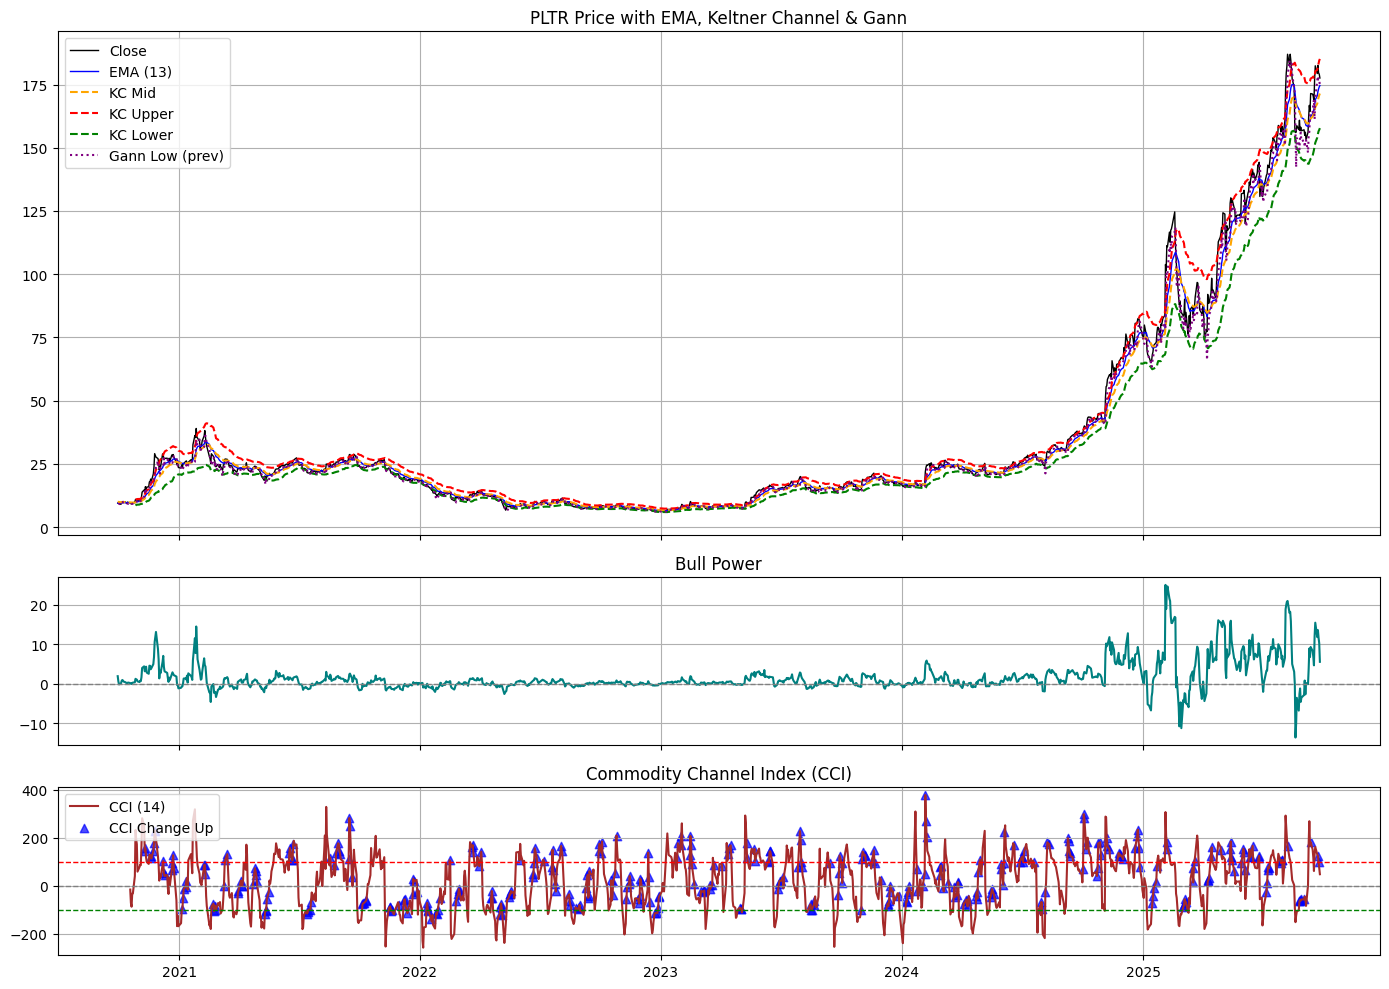

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------
# Plotting
# -------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# === 1. Price with EMA, KC, Gann ===
axes[0].plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
axes[0].plot(df.index, df['EMA'], label='EMA (13)', color='blue', linewidth=1)
axes[0].plot(df.index, df['KC_Mid'], label='KC Mid', color='orange', linestyle='--')
axes[0].plot(df.index, df['KC_Upper'], label='KC Upper', color='red', linestyle='--')
axes[0].plot(df.index, df['KC_Mid'] - (df['KC_Upper'] - df['KC_Mid']), label='KC Lower', color='green', linestyle='--')

# Gann HiLo
axes[0].plot(df.index, df['Gann_Low'], label='Gann Low (prev)', color='purple', linestyle=':')

axes[0].set_title(f"{symbol} Price with EMA, Keltner Channel & Gann")
axes[0].legend(loc='upper left')
axes[0].grid(True)

# === 2. Bull Power ===
axes[1].plot(df.index, df['Bull_Power'], label='Bull Power', color='teal')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title("Bull Power")
axes[1].grid(True)

# === 3. CCI ===
axes[2].plot(df.index, df['CCI_main'], label='CCI (14)', color='brown')
axes[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[2].axhline(100, color='red', linestyle='--', linewidth=1)
axes[2].axhline(-100, color='green', linestyle='--', linewidth=1)
axes[2].set_title("Commodity Channel Index (CCI)")
axes[2].grid(True)

# Highlight CCI Change Up
axes[2].scatter(df.index[df['CCI_Change_Up']], df['CCI_main'][df['CCI_Change_Up']],
                color='blue', marker='^', label='CCI Change Up', alpha=0.7)
axes[2].legend(loc='upper left')

# === Formatting ===
plt.tight_layout()
axes[2].xaxis.set_major_locator(mdates.YearLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2020-09-30 00:00:00
End                           2025-09-26 00:00:00
Period                         1254 days 00:00:00
Start Value                              100000.0
End Value                          1789349.975586
Total Return [%]                      1689.349976
Benchmark Return [%]                  1689.349976
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        84.876075
Max Drawdown Duration           926 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1689349.975586
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN
